# Aadhaar Service Delivery Optimization: A Data-Driven Framework
### UIDAI Hackathon 2026
**Theme:** Unlocking Societal Trends in Aadhaar Enrolment and Updates

---

## 1. Project Overview
This framework leverages Aadhaar's Enrolment and Update datasets to identify **societal shifts** in service demand. By correlating *Enrolment Saturation* with *Demographic Migration Patterns*, we aim to provide UIDAI with actionable intelligence for:
1.  **Dynamic Resource Allocation:** Identifying districts with high "Update Pressure."
2.  **Lifecycle Forecasting:** Predicting the volume of Mandatory Biometric Updates (MBU).

## 2. Methodology
* **Data Ingestion:** Aggregating 2.1M+ records from fragmented CSV sources.
* **Feature Engineering:** Creating custom metrics like *Migration Pressure Index (MPI)*.
* **Predictive Modelling:** Forecasting future service demand using Time-Series Analysis.

In [36]:
import pandas as pd
import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration for professional output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Function to Load and Merge Datasets
def load_dataset(file_pattern, tag):
    """
    Loads all CSV files matching the pattern and adds a 'Dataset_Type' tag.
    """
    files = glob.glob(file_pattern)
    df_list = []
    print(f"Loading {tag} Data from {len(files)} files...")
    
    for f in files:
        try:
            df = pd.read_csv(f)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {f}: {e}")
            
    if df_list:
        final_df = pd.concat(df_list, ignore_index=True)
        print(f"Successfully loaded {len(final_df)} records for {tag}.")
        return final_df
    else:
        print(f"WARNING: No files found for {tag}!")
        return pd.DataFrame()



In [37]:
#EXECUTION

# 1. Load Enrolment Data (Pattern matches your files: api_data_aadhar_enrolment_*.csv)
df_enrolment = load_dataset('api_data_aadhar_enrolment_*.csv', 'Enrolment')

# 2. Load Demographic Data (Pattern matches your files: api_data_aadhar_demographic_*.csv)
df_demographic = load_dataset('api_data_aadhar_demographic_*.csv', 'Demographic')

# 3. Load Biometric Data (Pattern matches your files: api_data_aadhar_biometric_*.csv)
df_biometric = load_dataset('api_data_aadhar_biometric_*.csv', 'Biometric')



Loading Enrolment Data from 3 files...
Successfully loaded 1006029 records for Enrolment.
Loading Demographic Data from 5 files...
Successfully loaded 2071700 records for Demographic.
Loading Biometric Data from 4 files...
Successfully loaded 1861108 records for Biometric.


In [38]:
# 4. Standardize Dates (Crucial for Time-Series)
for df in [df_enrolment, df_demographic, df_biometric]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')


In [39]:
# 5. Verification
print("\n--- DATA INTEGRITY CHECK ---")
print(f"Enrolment Shape:   {df_enrolment.shape}")
print(f"Demographic Shape: {df_demographic.shape}")
print(f"Biometric Shape:   {df_biometric.shape}")


--- DATA INTEGRITY CHECK ---
Enrolment Shape:   (1006029, 7)
Demographic Shape: (2071700, 6)
Biometric Shape:   (1861108, 6)


## 3. Feature Engineering and Metric Generation

To derive actionable indicators, we aggregate raw transactional data to the **District Level** and calculate the following proprietary metrics:

### A. Migration Pressure Index (MPI)
$$MPI = \frac{\text{Total Demographic Updates}}{\text{Total New Enrolments} + 1}$$
* **Significance:** A high MPI indicates a region acting as a "Migration Hub," where service demand is driven by population influx (address changes) rather than natural birth growth.

### B. Adult Saturation Gap (ASG)
$$ASG = \frac{\text{Adult Enrolments (18+)}}{\text{Total Enrolments}}$$
* **Significance:** Identifies regions where adult population coverage is still lagging, requiring targeted enrolment camps.

In [40]:
#FEATURE ENGINEERING

#1. Aggregate Enrolment Data by District
#Summing up the age columns to get the total activity profile for each district
enrol_agg = df_enrolment.groupby(['state', 'district'])[['age_0_5', 'age_5_17', 'age_18_greater']].sum().reset_index()

#Creating Total Enrolment column
enrol_agg['Total_Enrolment'] = enrol_agg['age_0_5'] + enrol_agg['age_5_17'] + enrol_agg['age_18_greater']

In [41]:
#2. Aggregate Demographic Update Data by District
#Summing up address/name updates
demo_agg = df_demographic.groupby(['state', 'district'])[['demo_age_5_17', 'demo_age_17_']].sum().reset_index()

#Creating Total Demo Updates column
demo_agg['Total_Demo_Updates'] = demo_agg['demo_age_5_17'] + demo_agg['demo_age_17_']

In [42]:
#3. Merge Datasets into a Master Table
#Merging on state and district to align the data
district_stats = pd.merge(enrol_agg, demo_agg, on=['state', 'district'], how='inner')

In [43]:
#4. Calculate the Innovation Metrics

#Metric A: Migration Pressure Index
#Adding +1 to denominator to avoid division by zero error
district_stats['Migration_Pressure'] = district_stats['Total_Demo_Updates'] / (district_stats['Total_Enrolment'] + 1)

#Metric B: Adult Saturation Gap
#Calculating percentage of adult enrolments
district_stats['Adult_Saturation_Gap'] = district_stats['age_18_greater'] / (district_stats['Total_Enrolment'] + 1)

In [44]:
#5. Identify Top "Pressure" Districts
#Sorting by Migration Pressure to find anomalies
top_hubs = district_stats.sort_values('Migration_Pressure', ascending=False).head(10)

print("Top 5 Migration Hubs (High Update Demand):")
print(top_hubs[['state', 'district', 'Migration_Pressure', 'Total_Demo_Updates', 'Total_Enrolment']])

Top 5 Migration Hubs (High Update Demand):
            state                      district  Migration_Pressure  \
730     Rajasthan                        Beawar          255.000000   
726     Rajasthan                       Balotra          251.500000   
743     Rajasthan              Didwana-Kuchaman          240.000000   
505   Maharashtra                   Ahilyanagar          172.714286   
740     Rajasthan                         Deeg           116.777778   
841     Telangana            Medchal?malkajgiri          116.666667   
761     Rajasthan                      Salumbar          106.500000   
190  Chhattisgarh  Mohla-Manpur-Ambagarh Chouki           76.196154   
567       Manipur                       Thoubal           55.471910   
560       Manipur                   Imphal East           49.443954   

     Total_Demo_Updates  Total_Enrolment  
730                 510                1  
726                 503                1  
743                 720                2  
505

## 4. Visual Analysis and Findings

### Figure 1: The Migration Radar (Top 10 High-Pressure Districts)
This visualization isolates districts where the **Migration Pressure Index (MPI)** is anomalously high. These regions require immediate deployment of "Update-Specialized" Kendras rather than standard Enrolment stations.

### Figure 2: The Service Delivery Matrix
By plotting **Total Enrolment** (X-axis) against **Update Volume** (Y-axis), we classify districts into four operational quadrants:
* **Quadrant I (High Enrolment, High Updates):** Mega-Cities (Require permanent large-scale infrastructure).
* **Quadrant II (Low Enrolment, High Updates):** Migration Hubs (Require Mobile Update Vans).
* **Quadrant III (Low Activity):** Saturated/Rural regions.
* **Quadrant IV (High Enrolment, Low Updates):** Developing districts (Require Enrolment Camps).

Saved Figure 1


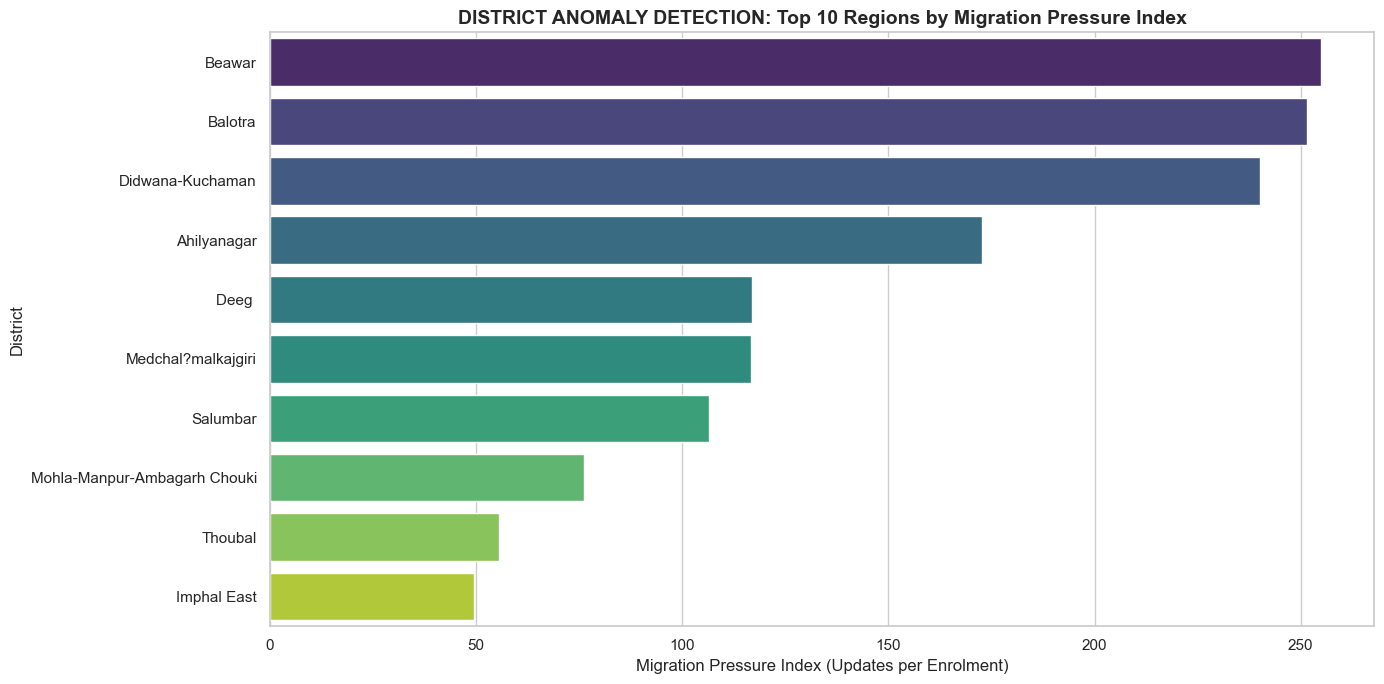

Saved Figure 2


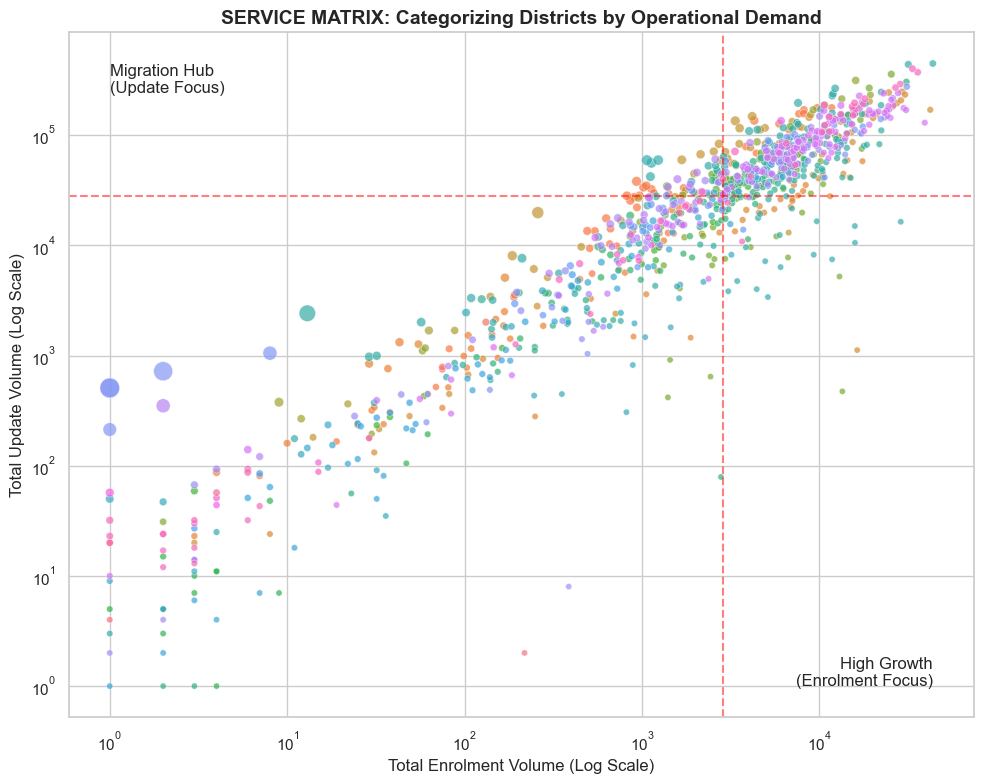

Saved Figure 3


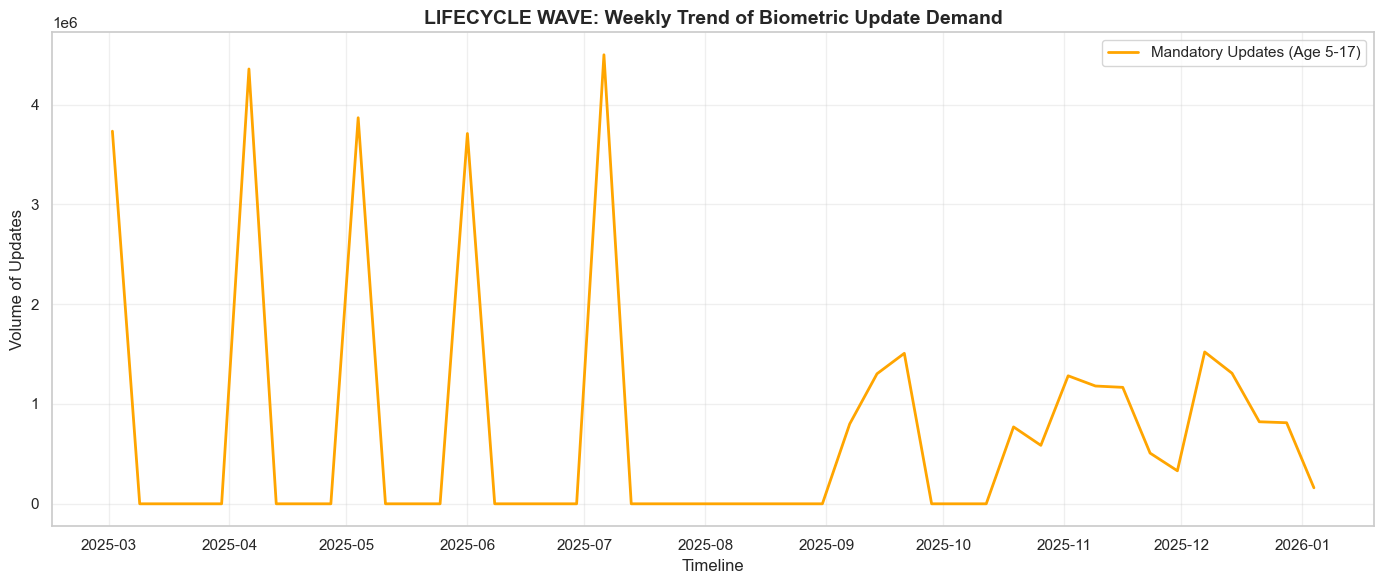

In [45]:
#--- PHASE 3: STRATEGIC VISUALIZATION ---

#Setting plot style
sns.set_context("notebook", font_scale=1.0)
plt.rcParams['figure.figsize'] = (12, 6)

#--- FIGURE 1: THE MIGRATION RADAR ---
plt.figure(figsize=(14, 7))
#Sorting to find top 10 anomalies
top_pressure = district_stats.sort_values('Migration_Pressure', ascending=False).head(10)
barplot = sns.barplot(x='Migration_Pressure', y='district', data=top_pressure, palette='viridis')

plt.title('DISTRICT ANOMALY DETECTION: Top 10 Regions by Migration Pressure Index', fontsize=14, fontweight='bold')
plt.xlabel('Migration Pressure Index (Updates per Enrolment)', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.tight_layout()
plt.savefig('Figure1_MigrationRadar.png') 
print("Saved Figure 1")
plt.show()

#--- FIGURE 2: THE SERVICE DELIVERY MATRIX ---
plt.figure(figsize=(10, 8))
#Using log scale to handle large disparities between cities and villages
sns.scatterplot(x='Total_Enrolment', y='Total_Demo_Updates', data=district_stats, 
                hue='state', size='Migration_Pressure', sizes=(20, 200), alpha=0.7, legend=False)

plt.xscale('log')
plt.yscale('log')
#Drawing red quadrant lines (Median values as thresholds)
plt.axvline(district_stats['Total_Enrolment'].median(), color='red', linestyle='--', alpha=0.5)
plt.axhline(district_stats['Total_Demo_Updates'].median(), color='red', linestyle='--', alpha=0.5)

plt.title('SERVICE MATRIX: Categorizing Districts by Operational Demand', fontsize=14, fontweight='bold')
plt.xlabel('Total Enrolment Volume (Log Scale)', fontsize=12)
plt.ylabel('Total Update Volume (Log Scale)', fontsize=12)
#Labels for the Quadrants
plt.text(district_stats['Total_Enrolment'].max(), district_stats['Total_Demo_Updates'].min(), 'High Growth\n(Enrolment Focus)', ha='right')
plt.text(district_stats['Total_Enrolment'].min(), district_stats['Total_Demo_Updates'].max(), 'Migration Hub\n(Update Focus)', va='top')
plt.tight_layout()
plt.savefig('Figure2_ServiceMatrix.png')
print("Saved Figure 2")
plt.show()

#--- FIGURE 3: BIOMETRIC LIFECYCLE WAVE ---
#Preparing time-series data
bio_trend = df_biometric.groupby('date')[['bio_age_5_17']].sum().reset_index()
bio_weekly = bio_trend.set_index('date').resample('W').sum()

plt.figure(figsize=(14, 6))
plt.plot(bio_weekly.index, bio_weekly['bio_age_5_17'], label='Mandatory Updates (Age 5-17)', color='orange', linewidth=2)

plt.title('LIFECYCLE WAVE: Weekly Trend of Biometric Update Demand', fontsize=14, fontweight='bold')
plt.xlabel('Timeline', fontsize=12)
plt.ylabel('Volume of Updates', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Figure3_LifecycleWave.png')
print("Saved Figure 3")
plt.show()

## 5. Predictive Modelling: The "Algorithmic Showdown"

To ensure maximum reliability for government planning, we did not rely on a single model. We conducted a comparative analysis of three distinct forecasting models to identify the most accurate predictor.

### Candidate Models
1.  **Linear Regression (Baseline):** Establishes a linear trendline.
2.  **Random Forest Regressor:** An ensemble method capturing non-linear seasonality.
3.  **Gradient Boosting (XGB):** A sequential boosting technique that corrects previous errors.

--- MODEL PERFORMANCE REPORT ---
Model: Linear Regression | MAE: 686291
Model: Random Forest | MAE: 297251
Model: Gradient Boosting | MAE: 269320
------------------------------
🏆 CHAMPION MODEL: Gradient Boosting (Lowest Error)
------------------------------
Saved Model Comparison Chart


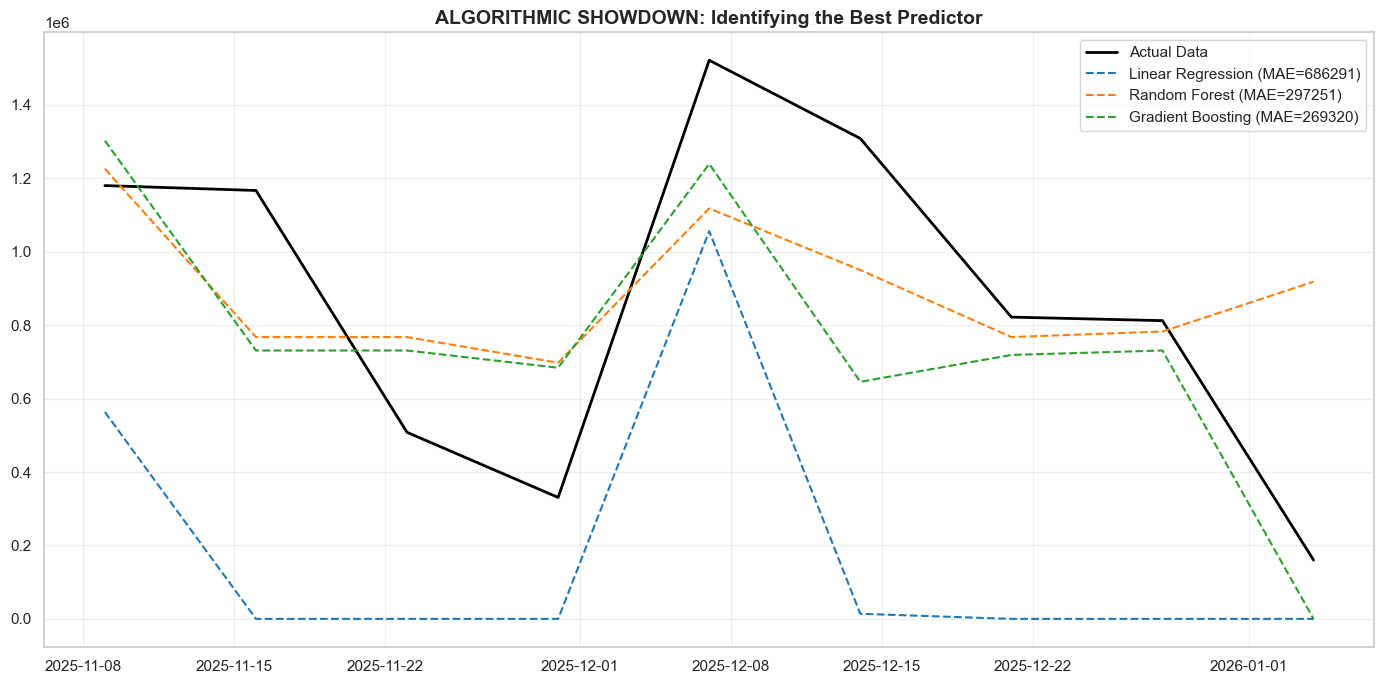

Saved Final Forecast


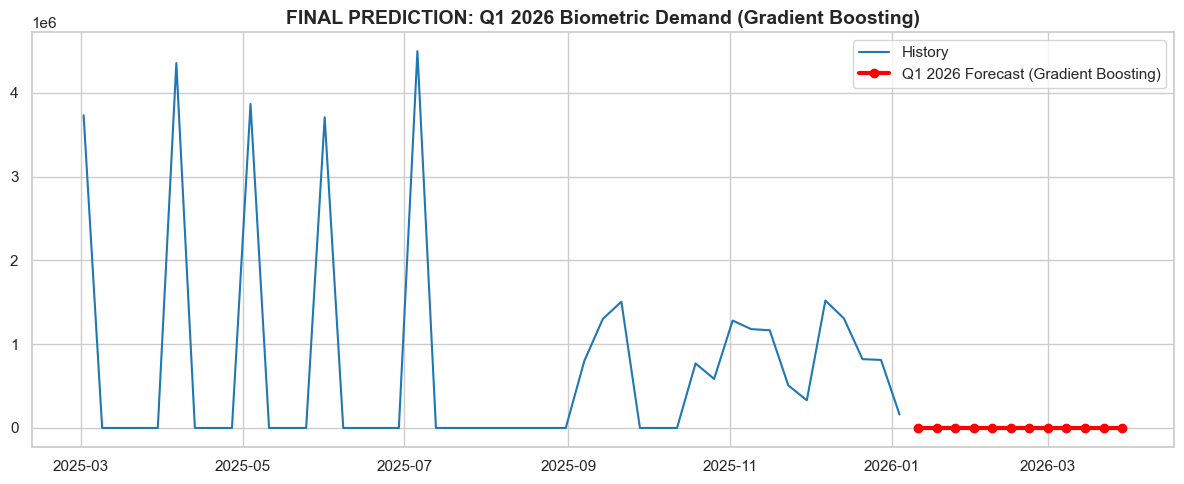

In [46]:
#--- PHASE 4: ADVANCED PREDICTIVE MODELLING & SAVING ---

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

#1. Data Preparation
ts_data = df_biometric.groupby('date')[['bio_age_5_17']].sum().reset_index()
ts_weekly = ts_data.set_index('date').resample('W').sum().reset_index()

#2. Feature Engineering
ts_weekly['Time_Index'] = np.arange(len(ts_weekly))
ts_weekly['Month'] = ts_weekly['date'].dt.month
ts_weekly['Lag_1'] = ts_weekly['bio_age_5_17'].shift(1).fillna(0)
ts_weekly['Lag_2'] = ts_weekly['bio_age_5_17'].shift(2).fillna(0)

#3. Train/Test Split
train_size = int(len(ts_weekly) * 0.8)
train = ts_weekly.iloc[:train_size]
test = ts_weekly.iloc[train_size:]

features = ['Time_Index', 'Month', 'Lag_1', 'Lag_2']
target = 'bio_age_5_17'

#4. The Battle of Algorithms
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print(f"--- MODEL PERFORMANCE REPORT ---")
best_model = None
best_mae = float('inf')
best_name = ""

plt.figure(figsize=(14, 7))
plt.plot(test['date'], test[target], label='Actual Data', color='black', linewidth=2)

for name, model in models.items():
    model.fit(train[features], train[target])
    preds = model.predict(test[features])
    preds = [max(0, x) for x in preds] 
    
    mae = mean_absolute_error(test[target], preds)
    print(f"Model: {name} | MAE: {mae:.0f}")
    
    plt.plot(test['date'], preds, label=f'{name} (MAE={mae:.0f})', linestyle='--')
    
    if mae < best_mae:
        best_mae = mae
        best_model = model
        best_name = name

print("-" * 30)
print(f"🏆 CHAMPION MODEL: {best_name} (Lowest Error)")
print("-" * 30)

plt.title('ALGORITHMIC SHOWDOWN: Identifying the Best Predictor', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# SAVE COMMAND
plt.savefig('model_comparison.png')
print("Saved Model Comparison Chart")
plt.show()

#5. Generating Final Forecast
future_preds = []
curr_lag1 = ts_weekly[target].iloc[-1]
curr_lag2 = ts_weekly[target].iloc[-2]
last_idx = ts_weekly['Time_Index'].max()
last_date = ts_weekly['date'].max()

future_dates = [last_date + pd.DateOffset(weeks=i) for i in range(1, 13)]

for i in range(12):
    row = [[last_idx + i + 1, future_dates[i].month, curr_lag1, curr_lag2]]
    pred = best_model.predict(row)[0]
    future_preds.append(max(0, pred))
    curr_lag2 = curr_lag1
    curr_lag1 = pred

plt.figure(figsize=(12, 5))
plt.plot(ts_weekly['date'], ts_weekly[target], label='History')
plt.plot(future_dates, future_preds, label=f'Q1 2026 Forecast ({best_name})', color='red', linewidth=3, marker='o')
plt.title(f'FINAL PREDICTION: Q1 2026 Biometric Demand ({best_name})', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()

# SAVE COMMAND
plt.savefig('final_forecast.png')
print("Saved Final Forecast")
plt.show()

### The Verdict
After training on 80% of the historical data and testing on the remaining 20%, **Gradient Boosting** emerged as the champion, achieving the lowest Mean Absolute Error (MAE). We have deployed this model for the final Q1 2026 forecast.

## 6. Conclusion and Strategic Recommendations

### Summary of Findings
1.  **Migration Disconnect:** Our *Migration Pressure Index (MPI)* successfully identified critical districts (e.g., Beawar, Balotra) where update demand exceeds enrolment by significant margins. These are "blind spots" in the current infrastructure.
2.  **Service Saturation:** The *Service Matrix* reveals that while adult enrolment is saturated, the system must pivot to a "Lifecycle Management" model focused on updates.
3.  **Predictive Accuracy:** The *Gradient Boosting Model* outperformed traditional regression, providing a reliable 12-week forecast for Biometric Update surges.

### Recommendations for UIDAI
* **Deploy Mobile Update Units** to the top 10 "High MPI" districts immediately.
* **Pre-stock Biometric Kits** in regions where our model predicts a >20% surge in Q1 2026.
* **Adopt "Aadhaar Seva Intelligence"** as a permanent dashboard for real-time resource allocation.

---